<a href="https://colab.research.google.com/github/MahmoudAlsayes/pythonProject/blob/master/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json


In [2]:
!kaggle competitions download -c data-science-bowl-2018


 99% 354M/358M [00:03<00:00, 63.3MB/s]
100% 358M/358M [00:03<00:00, 107MB/s] 


In [8]:
!kaggle competitions download -c data-science-bowl-2018 -p /content/data-science-bowl-2018


 97% 346M/358M [00:01<00:00, 268MB/s]
100% 358M/358M [00:01<00:00, 264MB/s]


In [9]:
!unzip /content/data-science-bowl-2018/*.zip -d /content/data-science-bowl-2018


Archive:  /content/data-science-bowl-2018/data-science-bowl-2018.zip
  inflating: /content/data-science-bowl-2018/stage1_sample_submission.csv.zip  
  inflating: /content/data-science-bowl-2018/stage1_solution.csv.zip  
  inflating: /content/data-science-bowl-2018/stage1_test.zip  
  inflating: /content/data-science-bowl-2018/stage1_train.zip  
  inflating: /content/data-science-bowl-2018/stage1_train_labels.csv.zip  
  inflating: /content/data-science-bowl-2018/stage2_sample_submission_final.csv.zip  
  inflating: /content/data-science-bowl-2018/stage2_test_final.zip  


In [ ]:
/content/data-science-bowl-2018.zip

In [13]:
import zipfile
with zipfile.ZipFile("data-science-bowl-2018.zip", 'r') as zip_ref:
    zip_ref.extractall("data-science")

In [10]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [14]:
import zipfile
TRAIN_ZIP = '/content/data-science-bowl-2018/stage1_train.zip'
TEST_ZIP = '/content/data-science-bowl-2018/stage1_test.zip'
# Directory where to extract
TRAIN_PATH = '/kaggle/working/stage1_train/'
TEST_PATH = '/kaggle/working/stage1_test/'

# Unzip the train data
with zipfile.ZipFile(TRAIN_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TRAIN_PATH)

# Unzip the test data
with zipfile.ZipFile(TEST_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TEST_PATH)

print("Extraction complete!")

Extraction complete!


In [15]:
train_ids = next(os.walk(TRAIN_PATH))[1] #gives the folder names
test_ids = next(os.walk(TEST_PATH))[1]

In [16]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [17]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [18]:
X_train.shape, Y_train.shape

((670, 128, 128, 3), (670, 128, 128, 1))

In [19]:
seed = 42
np.random.seed = seed

In [20]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # After resizing, ensure the data is in uint8 format and the range [0, 255]
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255)  # Clip values
        img = img.astype(np.uint8)  # Convert to uint8
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask_ = mask_.astype(np.uint8)

        mask = np.maximum(mask, mask_)
    # Convert the mask to boolean
    mask = (mask > 0).astype(bool)
    Y_train[n] = mask

100%|██████████| 670/670 [04:11<00:00,  2.67it/s]


In [21]:
X_train[0].shape, Y_train[0].shape

((128, 128, 3), (128, 128, 1))

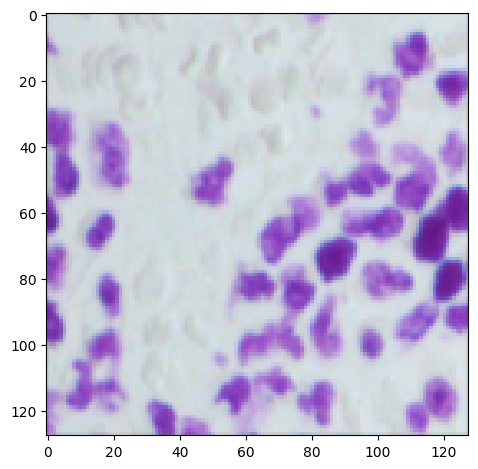

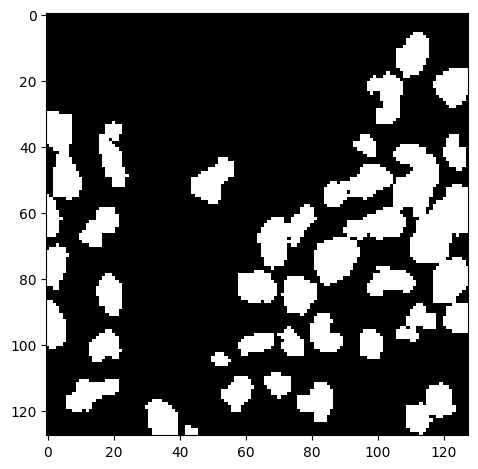

In [22]:
imshow(X_train[0])
plt.show()
imshow(Y_train[0])
plt.show()

In [23]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # print(img.dtype)
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255)  # Clip values
        img = img.astype(np.uint8)  # Convert to uint8
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 49.90it/s]

Done!


89

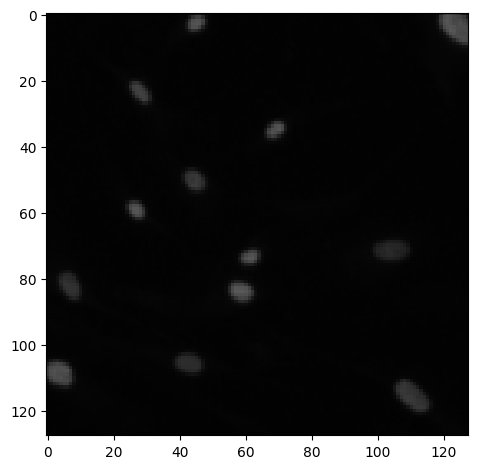

In [24]:
sizes_test[1]
imshow(X_test[1])
X_test[1].max()

5


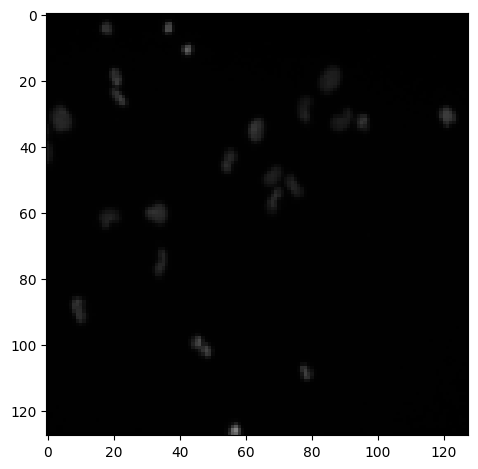

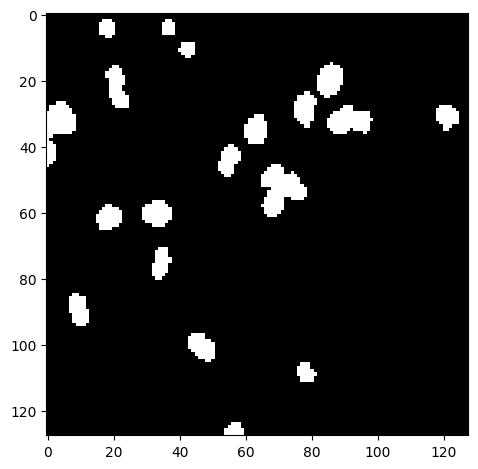

In [25]:
image_x = random.randint(0, len(train_ids))
print(image_x)

imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [27]:
!pip install -U segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00


In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,preprocessing
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer
inputs=layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

x = base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs =layers.Dense(1,activation="sigmoid", name="output_layer")(x)

model_1=keras.Model(inputs,outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [26]:
# #Build the model
# inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# #Contraction path
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# c1 = tf.keras.layers.Dropout(0.1)(c1)
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = tf.keras.layers.Dropout(0.1)(c2)
# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = tf.keras.layers.Dropout(0.2)(c3)
# c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = tf.keras.layers.Dropout(0.2)(c4)
# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = tf.keras.layers.Dropout(0.3)(c5)
# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# #Expansive path
# u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = tf.keras.layers.concatenate([u6, c4])
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# c6 = tf.keras.layers.Dropout(0.2)(c6)
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = tf.keras.layers.concatenate([u7, c3])
# c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = tf.keras.layers.Dropout(0.2)(c7)
# c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = tf.keras.layers.concatenate([u8, c2])
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# c8 = tf.keras.layers.Dropout(0.1)(c8)
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = tf.keras.layers.Dropout(0.1)(c9)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

# model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
import datetime

In [35]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Defining callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.keras', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model_for_nuclei.keras', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')
    tensorboard_callback
]

In [36]:
# Clear any logs from previous runs
!rm -rf /kaggle/working/logs

In [37]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=35, callbacks=callbacks)

Epoch 1/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7833 - loss: 0.5970
Epoch 1: val_loss improved from inf to 0.31166, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 527ms/step - accuracy: 0.7837 - loss: 0.5952 - val_accuracy: 0.8359 - val_loss: 0.3117
Epoch 2/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8385 - loss: 0.3001
Epoch 2: val_loss improved from 0.31166 to 0.17438, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8392 - loss: 0.2991 - val_accuracy: 0.9309 - val_loss: 0.1744
Epoch 3/35
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9350 - loss: 0.1745
Epoch 3: val_loss improved from 0.17438 to 0.13084, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9351 - loss: 0.1743 - val_accuracy: 0.9535 - val_loss: 0.1308
Epoch 4/35
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9502 - loss: 0.1391
Epoch 4: val_loss improved from 0.13084 

In [38]:
# type(results)
results.history

{'accuracy': [0.7986614108085632,
  0.864899218082428,
  0.9399341940879822,
  0.9513712525367737,
  0.9538410305976868,
  0.9571536183357239,
  0.9600067734718323,
  0.9604229927062988,
  0.9631448984146118,
  0.9637370109558105,
  0.965067446231842,
  0.965315043926239],
 'loss': [0.5234962105751038,
  0.26344993710517883,
  0.16376625001430511,
  0.13448287546634674,
  0.12356166541576385,
  0.11277739703655243,
  0.10391845554113388,
  0.10383697599172592,
  0.09798439592123032,
  0.09482794255018234,
  0.09213240444660187,
  0.09079036116600037],
 'val_accuracy': [0.8358947038650513,
  0.9309428334236145,
  0.9534684419631958,
  0.9553741812705994,
  0.961065948009491,
  0.9642989635467529,
  0.9643126726150513,
  0.9647508263587952,
  0.9660717248916626,
  0.96783447265625,
  0.9678882360458374,
  0.9670892953872681],
 'val_loss': [0.3116593658924103,
  0.17437569797039032,
  0.13083700835704803,
  0.11940215528011322,
  0.09803809970617294,
  0.09339644759893417,
  0.09411017596

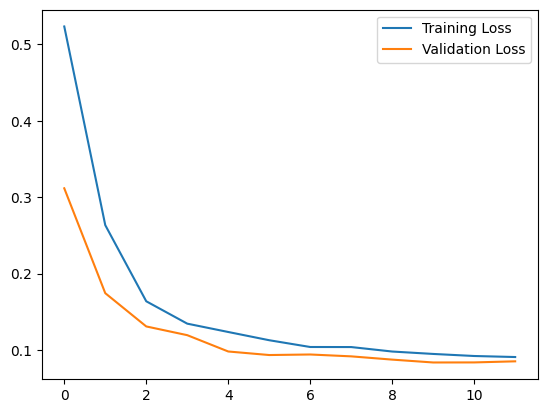

In [39]:
history = results.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

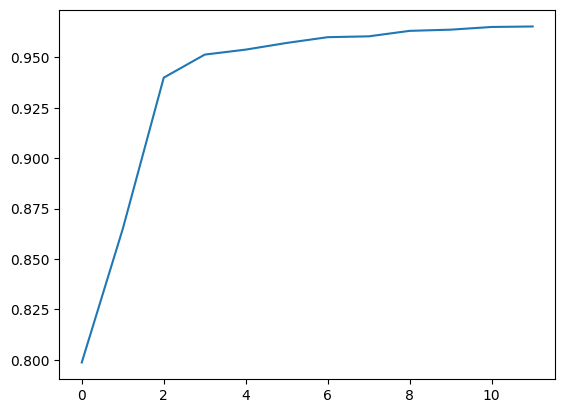

In [40]:
history = results.history
plt.plot(history['accuracy'], label='Accuracy')
plt.show()

In [41]:
model.input_shape

(None, 128, 128, 3)

In [42]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(128, 128, 1)


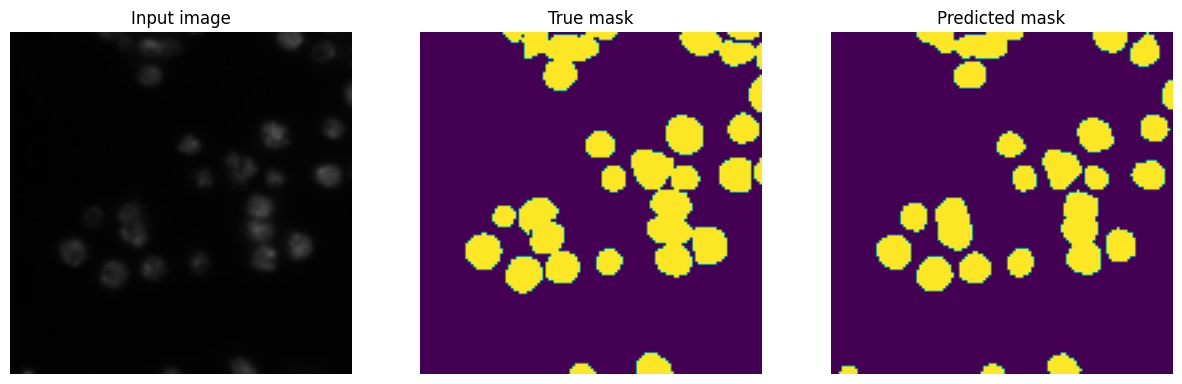

In [49]:
idx = random.randint(0, len(X_train))
true_image = X_train[idx]
true_mask = np.squeeze(Y_train[idx])
# Add batch dimension and then predict
prediction = model.predict(true_image[tf.newaxis, ...])[0]

predicted_mask = (prediction > 0.5).astype(np.uint8)
print(predicted_mask.shape)
display([true_image, true_mask,predicted_mask])

In [44]:
model.save('/kaggle/working/unet.h5')

In [45]:
predicted_masks = model.predict(X_train)
# For binary segmentation, we usually apply a threshold of 0.5
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)

# Now `predicted_masks` is an array of shape (670, 128, 128, 1), similar to `y_train`
print(predicted_masks.shape)

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step
(670, 128, 128, 1)


In [46]:
# Create directories to save the true and predicted masks
true_masks_folder = '/kaggle/working/true_masks'
predicted_masks_folder = '/kaggle/working/predicted_masks'
os.makedirs(true_masks_folder, exist_ok=True)
os.makedirs(predicted_masks_folder, exist_ok=True)


In [47]:
import shutil
import imageio
# Assuming `true_masks` and `predicted_masks` are numpy arrays of shape (670, 128, 128, 1)
# Iterate through all masks and save them as PNG images
for i in range(len(X_train)):  # Adjust the range based on the number of masks
    # Get the i-th true and predicted mask
    true_mask = np.squeeze(Y_train[i])  # Squeeze to remove the single channel dimension (128, 128)
    predicted_mask = np.squeeze(predicted_masks[i])

    # Create the paths to save the images
    true_mask_save_path = os.path.join(true_masks_folder, f'true_mask_{i}.png')
    predicted_mask_save_path = os.path.join(predicted_masks_folder, f'predicted_mask_{i}.png')

    # Save the true and predicted masks as images
    imageio.imwrite(true_mask_save_path, (true_mask * 255).astype(np.uint8))  # Scale if necessary
    imageio.imwrite(predicted_mask_save_path, (predicted_mask * 255).astype(np.uint8))

print("True and Predicted masks saved in their respective folders.")

True and Predicted masks saved in their respective folders.


In [48]:
# Now create zip archives for both directories
shutil.make_archive('/kaggle/working/true_masks_archive', 'zip', true_masks_folder)
shutil.make_archive('/kaggle/working/predicted_masks_archive', 'zip', predicted_masks_folder)

print("Masks folders zipped successfully.")

Masks folders zipped successfully.
